## Load the data

Load train and test data in memory

In [1]:
import gzip
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def read_mnist(images_path: str, labels_path: str):
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)
        
    return features, labels

In [3]:
train = {}
test = {}

train['features'], train['labels'] = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

In [4]:
#test['features'][0]

### Explore the data

It is always a good to do some data exploration before we start using it, find outliers, and decide if we need a preprocessing phase to uniform or augment it. And also to make sure that all the classes are covered by or more or less the same number of samples.


In [5]:
print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])

# of training images: 60000
# of test images: 10000


#### Display some images

In [6]:
def display_image(position):
    image = train['features'][position].squeeze()
    plt.title('Example %d. Label: %d' % (position, train['labels'][position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

#### Plot training data

In [7]:
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


### Split training data into training and validation

In [8]:
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

In [9]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

# of training images: 48000
# of validation images: 12000


## 2. Prepare our input features

The LeNet architecture accepts a 32x32 pixel images as input, mnist data is 28x28 pixels. We simply pad the images with zeros to overcome that.

In [10]:
# Pad images with 0s
train['features']      = np.pad(train['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
validation['features'] = np.pad(validation['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
test['features']       = np.pad(test['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(train['features'][0].shape))

Updated Image Shape: (32, 32, 1)


## 3. LeNet-5 implmentation

#### Input
    32x32x1 pixels image

#### Architecture
* **Convolutional #1** outputs 28x28x6
    * **Activation** any activation function, we will `relu`

* **Pooling #1** The output shape should be 14x14x6.

* **Convolutional #2** outputs 10x10x16.
    * **Activation** any activation function, we will `relu`

* **Pooling #2** outputs 5x5x16.
    * **Flatten** Flatten the output shape of the final pooling layer

* **Fully Connected #1** outputs 120
    * **Activation** any activation function, we will `relu`

* **Fully Connected #2** outputs 84
    * **Activation** any activation function, we will `relu`

* **Fully Connected (Logits) #3** outpute 10


In [11]:
model = keras.Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=10, activation = 'softmax'))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_1 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_2 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               69240     
_________________________________________________________________
dense_2 (Dense)              (None, 84)               

In [13]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [14]:
EPOCHS = 10
BATCH_SIZE = 128

In [15]:
X_train, y_train = train['features'], to_categorical(train['labels'])
X_validation, y_validation = validation['features'], to_categorical(validation['labels'])

train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

In [16]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

steps_per_epoch = X_train.shape[0]//BATCH_SIZE
validation_steps = X_validation.shape[0]//BATCH_SIZE

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=True, callbacks=[tensorboard])

# of training images: 48000
# of validation images: 12000
Epoch 1/10
375/375 [==============================] - 38s 101ms/step - loss: 0.2555 - accuracy: 0.9217 - val_loss: 0.1179 - val_accuracy: 0.9749
Epoch 2/10
375/375 [==============================] - 37s 99ms/step - loss: 0.0763 - accuracy: 0.9761 - val_loss: 0.0799 - val_accuracy: 0.9784
Epoch 3/10
375/375 [==============================] - 35s 93ms/step - loss: 0.0462 - accuracy: 0.9856 - val_loss: 0.1146 - val_accuracy: 0.9848
Epoch 4/10
375/375 [==============================] - 37s 98ms/step - loss: 0.0383 - accuracy: 0.9879 - val_loss: 0.1692 - val_accuracy: 0.9815
Epoch 5/10
375/375 [==============================] - 33s 89ms/step - loss: 0.0266 - accuracy: 0.9914 - val_loss: 0.0143 - val_accuracy: 0.9858
Epoch 6/10
375/375 [==============================] - 30s 79ms/step - loss: 0.0231 - accuracy: 0.9924 - val_loss: 0.0271 - val_accuracy: 0.9826
Epoch 7/10
375/375 [==============================] - 37s 99ms/step - loss: 0

In [17]:
score = model.evaluate(test['features'], to_categorical(test['labels']))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 3s 254us/step
Test loss: 0.05238446573858855
Test accuracy: 0.9860000014305115


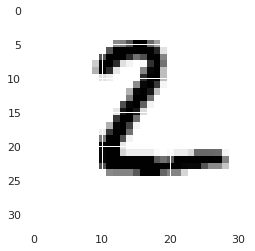

[[  0   0   0   0   0   0   0   0   0   0   0   0 116 125 171 255 255 150
   93   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 169 253 253 253 253 253 253
  218  30   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 169 253 253 253 213 142 176 253
  253 122   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  52 250 253 210  32  12   0   6 206
  253 140   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  77 251 210  25   0   0   0 122 248
  253  65   0   0   0   0   0   0   0   0   0   0   0   0]]


In [18]:
plt.imshow(test['features'][1][:,:,0],cmap=plt.cm.gray_r)
plt.show()
print(test['features'][1][5:10,:,0])

In [19]:
testcase = test['features'][1][:,:,0]
print(testcase.shape)
testcase = testcase[np.newaxis,:,:]
print(testcase.shape)
testcase = testcase[:,:,:,np.newaxis]
print(testcase.shape)

(32, 32)
(1, 32, 32)
(1, 32, 32, 1)


In [23]:
model.predict(testcase)

array([[1.6533672e-10, 5.4091220e-09, 1.0000000e+00, 1.2546227e-12,
        1.1491643e-10, 7.0295514e-15, 1.5817489e-10, 4.3433573e-10,
        1.8730222e-09, 7.4556509e-15]], dtype=float32)